<a href="https://colab.research.google.com/github/sayakpaul/neural-structured-learning/blob/master/research/denoised_smoothing/notebooks/Train_Denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!git clone https://github.com/sayakpaul/neural-structured-learning
!cd neural-structured-learning/research/denoised_smoothing && tar xf models.tar.gz

Cloning into 'Denoised-Smoothing-TF'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 93 (delta 37), reused 62 (delta 21), pack-reused 0
Unpacking objects: 100% (93/93), done.


In [ ]:
import sys
sys.path.append("neural-structured-learning/research/denoised_smoothing")

from models import dncnn

from tensorflow.keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

With a TPU, you would need to have a GCS Bucket to serialize and load the `SavedModel` files. 

In [ ]:
try: 
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: 
    strategy = tf.distribute.MirroredStrategy() 

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of accelerators:  4


## Load dataset

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


## Define constants

In [ ]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
EPOCHS = 90 
START_LR = 1e-3
AUTO = tf.data.AUTOTUNE

## Prepare data loaders

In [ ]:
# Augmentation pipeline
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(32, 32),
        layers.experimental.preprocessing.RandomFlip("horizontal")
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(BATCH_SIZE * 100)
    .map(lambda x: (tf.image.convert_image_dtype(x, tf.float32)), 
         num_parallel_calls=AUTO)
    .repeat()
    .batch(BATCH_SIZE)
    .map(data_augmentation, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Test dataset
test_ds = (
    tf.data.Dataset.from_tensor_slices(x_test)
    .map(lambda x: (tf.image.convert_image_dtype(x, tf.float32)), 
         num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Compute the mean and the variance of the training data for normalization
norm_layer = layers.experimental.preprocessing.Normalization()
norm_layer.adapt(x_train/255.) # Notice the scaling step

## Define training loop

In [ ]:
class Trainer(tf.keras.Model):
    def __init__(self, denoiser, classifier, sigma=0.25):
        super(Trainer, self).__init__()
        self.denoiser = denoiser
        self.classifier = classifier
        self.sigma = sigma
    
    def train_step(self, clean_inputs):
        batch_size = tf.shape(clean_inputs)[0]
        clean_inputs = tf.cast(clean_inputs, tf.float32)
        
        if self.classifier is not None:
            targets = self.classifier(clean_inputs, training=False)
        else:
            targets = clean_inputs

        with tf.GradientTape() as tape:
            noise = tf.experimental.numpy.random.randn(batch_size, 32, 32, 3) * self.sigma
            noisy_inputs = norm_layer(clean_inputs + noise) # Add noise BEFORE normalization
            clean_predictions = self.denoiser(noisy_inputs, training=True)

            if self.classifier is not None:
                clean_predictions = self.classifier(clean_predictions, 
                                                    training=False)
                loss = self.compiled_loss(targets, clean_predictions)
                loss = tf.nn.compute_average_loss(loss, 
                                                  global_batch_size=BATCH_SIZE)
            else:
                loss = self.compiled_loss(targets, clean_predictions)
                loss /= tf.cast(tf.reduce_prod(tf.shape(targets)[1:]), tf.float32)
                loss = tf.nn.compute_average_loss(loss, 
                                                  global_batch_size=BATCH_SIZE)

        trainable_vars = self.denoiser.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss}

    def test_step(self, clean_inputs):
        batch_size = tf.shape(clean_inputs)[0]
        clean_inputs = tf.cast(clean_inputs, tf.float32)
        
        if self.classifier is not None:
            targets = self.classifier(clean_inputs, training=False)
        else:
            targets = clean_inputs

        noise = tf.experimental.numpy.random.randn(batch_size, 32, 32, 3) * self.sigma
        noisy_inputs = norm_layer(clean_inputs + noise)
        clean_predictions = self.denoiser(noisy_inputs, training=False)

        if self.classifier is not None:
            clean_predictions = self.classifier(clean_predictions, 
                                                            training=False)
            loss = self.compiled_loss(targets, clean_predictions)
            loss = tf.nn.compute_average_loss(loss, 
                                                  global_batch_size=BATCH_SIZE)
        else:
            loss = self.compiled_loss(targets, clean_predictions)
            loss /= tf.cast(tf.reduce_prod(tf.shape(targets)[1:]), tf.float32)
            loss = tf.nn.compute_average_loss(loss, 
                                                global_batch_size=BATCH_SIZE)

        return {"loss": loss}

## LR schedule

In [ ]:
# https://github.com/cszn/DnCNN/blob/master/TrainingCodes/dncnn_keras/main_train.py
def lr_schedule(epoch):
    initial_lr = START_LR
    if epoch<=30:
        lr = initial_lr
    elif epoch<=60:
        lr = initial_lr/10
    elif epoch<=80:
        lr = initial_lr/20 
    else:
        lr = initial_lr/20 
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

## Training with the stability objective

From [this blog post](https://www.microsoft.com/en-us/research/blog/denoised-smoothing-provably-defending-pretrained-classifiers-against-adversarial-examples/):

> given a classifier $F$ attached to the denoiser $\mathcal{D}_{\theta}$, minimize the cross-entropy loss between the prediction of $F(\mathcal{D}_{theta})$ at the noisy input $x_i + \delta
$ and the prediction of the classifier at the clean data point $x_i$

$$\begin{align}L_{\text{Stab}}&=\mathbb{E}_{\mathcal{S}, \delta} \mathcal{\ell_\text{CE}}(F(\mathcal{D}_\theta(x_i + \delta)), f(x_i)) \quad \text{where} \; \delta \sim \mathcal{N}(0, \sigma^2 I) \; \end{align}$$

One can obtain the initial weights that I used from [here](https://github.com/sayakpaul/Denoised-Smoothing-TF/raw/main/models.tar.gz).

In [ ]:
with strategy.scope():
    pretrained_classifier = tf.keras.models.load_model("Denoised-Smoothing-TF/resnet20_classifier")
    denoiser = Trainer(dncnn.get_dncnn(), pretrained_classifier)
    denoiser.denoiser.save("initial_denoiser")
    denoiser.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=START_LR),
                     loss=tf.keras.losses.CategoricalCrossentropy(reduction="none")
    )

history = denoiser.fit(train_ds,
            steps_per_epoch=len(x_train)//BATCH_SIZE,
            validation_data=test_ds,
            epochs=EPOCHS,
            callbacks=[lr_scheduler])

INFO:tensorflow:Assets written to: initial_denoiser/assets
Epoch 1/90
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1
97/97 [==============================] - 42s 135ms/step - loss: 0.6532 - val_loss: 0.2795
Epoch 2/90
97/97 [==============================] - 7s 76ms/step - loss: 0.5013 - val_loss: 0.2699
Epoch 3/90
97/97 [==============================] - 7s 76ms/step - loss: 0.4726 - val_loss: 0.2519
Epoch 4/90
97/97 [==============================] - 7s 76ms/step - loss: 0.4553 - val_loss: 0.2569
Epoch 5/90
97/97 [==============================] - 7s 76ms/step - loss: 0.4462 - val_loss: 0.2513
Epoch 6/90
97/97 [==============================] - 7s 76ms/step - loss: 0.4304 - val_loss: 0.2535
Epoch 7/90
97/97 [==============================] - 7s 76ms/step - loss: 0.4230 - val_loss: 0.2321
Epoch 8/90
97/97 [==============================] - 7s 76ms/step - loss: 0

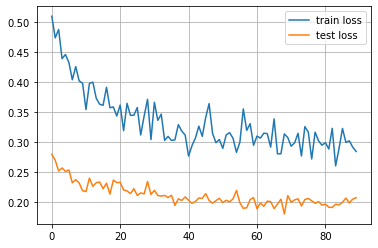

INFO:tensorflow:Assets written to: denoiser_stability/assets


In [ ]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="test loss")
plt.grid()
plt.legend()
plt.show()

denoiser.denoiser.save("denoiser_stability")

## With MSE objective

In [ ]:
with strategy.scope():
    initial_denoiser = tf.keras.models.load_model("initial_denoiser")
    denoiser = Trainer(initial_denoiser, classifier=None)
    denoiser.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=START_LR),
                     loss=tf.keras.losses.MeanSquaredError(reduction="none")
    )

history = denoiser.fit(train_ds,
            steps_per_epoch=len(x_train)//BATCH_SIZE,
            validation_data=test_ds,
            epochs=EPOCHS,
            callbacks=[lr_scheduler])

Epoch 1/90
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 62 all-reduces with algorithm = nccl, num_packs = 1
97/97 [==============================] - 24s 79ms/step - loss: 0.0604 - val_loss: 0.0183
Epoch 2/90
97/97 [==============================] - 5s 54ms/step - loss: 0.0144 - val_loss: 0.0076
Epoch 3/90
97/97 [==============================] - 5s 55ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 4/90
97/97 [==============================] - 5s 55ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 5/90
97/97 [==============================] - 5s 55ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 6/90
97/97 [==============================] - 5s 54ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 7/90
97/97 [==============================] - 5s 54ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 8/90
97/97 [==============================] - 5s 55ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 9/90
97/97 [=================

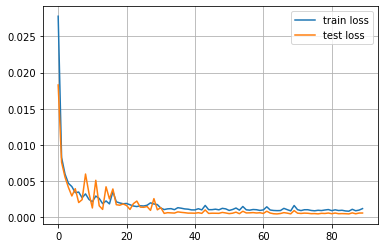

INFO:tensorflow:Assets written to: gs://denoised-smoothing-tf/denoiser_mse/assets


In [ ]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="test loss")
plt.grid()
plt.legend()
plt.show()

denoiser.denoiser.save("denoiser_mse")